In [5]:
!pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"arpitkumargupta","key":"bba778e802edc834f1daab046ada35e0"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d kritanjalijain/amazon-reviews

Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
License(s): CC0-1.0
amazon-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip amazon-reviews.zip
!ls

Archive:  amazon-reviews.zip
replace amazon_review_polarity_csv.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename:  amazon_review_polarity_csv.tgz   glove.6B.300d.txt   kaggle.json
 amazon-reviews.zip		  glove.6B.50d.txt    sample_data
 glove.6B.100d.txt		  glove.6B.zip	      test.csv
 glove.6B.200d.txt		 'kaggle (1).json'    train.csv


In [11]:
import pandas as pd
train_df = pd.read_csv('train.csv',header=None,nrows=100000)

train_df.rename(columns={0:'Label',1:'Title',2:'Review'},inplace=True)
train_df=train_df.dropna()
train_df=train_df.reset_index(drop=True)
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   99995 non-null  int64 
 1   Title   99995 non-null  object
 2   Review  99995 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB
None


In [13]:
positive_df=train_df[train_df['Label']==2]
negative_df=train_df[train_df['Label']==1]
print(train_df.head(100))

# # print(train_df.iloc[:1000,:][train_df['Review'].iloc[:1000].str.contains(r'\d')].head().to_string())
print(train_df['Review'].str.len().max())


#Better after tokenisation:

# l_a=[25*x for x in range(13,24)]
# lengths=[0,100,110,120,130,140,150,160]
# lengths.extend([20*x for x in range(9,16)])
# l_b=[600,630,660,700,750,800,850,900,1025]
# lengths.extend(l_a)
# lengths.extend(l_b)


# for i in range(1,35):
#     p=positive_df[(positive_df['Review'].str.len()<lengths[i])&(positive_df['Review'].str.len()>=lengths[i-1])].index.size
#     q=negative_df[(negative_df['Review'].str.len()<lengths[i])&(negative_df['Review'].str.len()>=lengths[i-1])].index.size
#     print(f"Length of sequence: {lengths[i-1]} to {lengths[i]} Number of positive reviews: {p} Number of Negative reviews: {q}, positive_class_percentage:{p/(q+p)}")


!pip  install symspellpy
!pip install pandarallel

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4)

import inflect
import re
import unicodedata
from symspellpy.symspellpy import SymSpell, Verbosity

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

func=inflect.engine()
lemmatiser=WordNetLemmatizer()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt",0,1)

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
keep_words = {
    'not', 'no', 'never', 'nor', 'very', 'too', 'so', 'just', 'really',
    'maybe', 'perhaps', 'definitely', 'surely', 'even', 'only', 'still',
    'yet', 'most', 'more', 'less', 'least', 'better', 'worse', 'best', 'worst',
    'always', 'already', 'clearly', 'almost', 'barely', 'hardly', 'scarcely',
    'totally', 'absolutely', 'completely', 'entirely', 'strongly', 'immensely',
        'certainly','undoubtedly', 'obviously','oh', 'wow', 'ugh','aha','oops','again','good', 'bad', 'much' }

contractions_dict = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is","'d": " would","'ll": " will","'t": " not","'ve": " have", "'m": " am"}

stop_words-=keep_words

DIGIT_RE = re.compile(r'\b\d{1,10}\b')
WHITESPACE_RE = re.compile(r'\s+')
NON_WORD_RE = re.compile(r'[^\w\s!?]')

def complete_preprocessor(text):

    def correct_spelling(text):
      suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
      if suggestions:
          return suggestions[0].term
      return text

    def num_to_text(text):
        def f(match):
            txt=match.group()
            return func.number_to_words(int(txt))
        return re.sub(DIGIT_RE,f,text)

    def fix_contractions(txt):
        for x,y in contractions_dict.items():
            pattern = re.compile(r'\b' + re.escape(x) + r'\b', flags=re.IGNORECASE)
            txt = pattern.sub(y, txt)
        return txt


    def get_wordnet_tag(tb_tag):
        if tb_tag.startswith('J'):
            return 'a'
        elif tb_tag.startswith('V'):
            return 'v'
        elif tb_tag.startswith('R'):
            return 'r'
        elif tb_tag.startswith('N'):
            return 'n'
        else:
            return None # To take care of relevant punctuations

    def lemmatise(ls):
        return [lemmatiser.lemmatize(token,get_wordnet_tag(tb_tag)) if get_wordnet_tag(tb_tag) else token for token, tb_tag in ls if token not in stop_words]

    if not isinstance(text,str):
        return text
    text=text.lower().strip()
    text=re.sub(WHITESPACE_RE, ' ', text)

    text=unicodedata.normalize('NFKD', text)
    text=num_to_text(text)
    text=re.sub(NON_WORD_RE,'', text)
    text=fix_contractions(text)
    text=correct_spelling(text)

    word_tokens=word_tokenize(text)
    tags=pos_tag(word_tokens)
    return lemmatise(tags)

#Rare Words later

train_df['Title']=train_df['Title'].parallel_apply(complete_preprocessor)
train_df['Review']=train_df['Review'].parallel_apply(complete_preprocessor)

train_df=train_df[(train_df['Title'].apply(len)>0)&(train_df['Review'].apply(len)>0)]
train_df=train_df.reset_index(drop=True)
train_df['Label']-=1

    Label                               Title  \
0       1              [stun, even, nongamer]   
1       1  [best, soundtrack, ever, anything]   
2       1                             [amaze]   
3       1             [excellent, soundtrack]   
4       1  [remember, pull, jaw, floor, hear]   
..    ...                                 ...   
95      0            [very, not, worth, time]   
96      1            [very, fun, educational]   
97      0                  [ludicrous, silly]   
98      1                          [artistry]   
99      0                           [caution]   

                                               Review  
0   [sound, track, beautiful, paint, senery, mind,...  
1   [im, read, lot, review, say, best, game, sound...  
2   [soundtrack, favorite, music, time, hand, inte...  
3   [truly, like, soundtrack, enjoy, video, game, ...  
4   [youve, play, game, know, divine, music, every...  
..                                                ...  
95  [book, wriiten,

2025-06-10 15:37:53,976: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en_82_765.txt.


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
!ls
!rm glove.6B.zip.1 glove.6B.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls

glove_input_file = 'glove.6B.100d.txt'

from nltk.corpus import sentiwordnet
nltk.download('sentiwordnet')



 amazon_review_polarity_csv.tgz   glove.6B.300d.txt   kaggle.json
 amazon-reviews.zip		  glove.6B.50d.txt    sample_data
 glove.6B.100d.txt		  glove.6B.zip	      test.csv
 glove.6B.200d.txt		 'kaggle (1).json'    train.csv
rm: cannot remove 'glove.6B.zip.1': No such file or directory
--2025-06-10 15:55:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-10 15:55:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-10 15:55:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downlo

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [35]:
# new_lengths=[0,100]
# new_lengths.extend([50*x for x in range(3,22)])

positive_df=train_df[train_df['Label']==2]
negative_df=train_df[train_df['Label']==1]

print(positive_df[positive_df['Review'].apply(len)==0].index.size)
print(negative_df[negative_df['Review'].apply(len)==0].index.size)
# for i in range(1,21):
#     p=positive_df[(positive_df['Review'].apply(len)<new_lengths[i])&(positive_df['Review'].apply(len)>=new_lengths[i-1])].index.size
#     q=negative_df[(negative_df['Review'].apply(len)<new_lengths[i])&(negative_df['Review'].apply(len)>=new_lengths[i-1])].index.size
#     print(f"Length of sequence: {new_lengths[i-1]} to {new_lengths[i]} Number of positive reviews: {p} Number of Negative reviews: {q}, positive_class_percentage:{p/(q+p)}")

from collections import Counter
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence

def build_vocab(df):
    counter=Counter()
    cols=['Title','Review']
    for col in cols:
        df[col].apply(lambda word_tokens: counter.update(word_tokens))
    vocab={'UNK':1,'PAD':0,'POS':2,'NEG':3}
    index=4
    for word,freq in counter.items():
        if freq>=1:
            vocab[word]=index
            index+=1
    return vocab

def int_tokens(df,vocab):

    def get_int_tokens(ls):
        return [vocab.get(token) if token in vocab else vocab.get('UNK') for token in ls]

    cols=['Title','Review']
    for col in cols:
        df[col]=df[col].apply(lambda x : get_int_tokens(x))

def seq_pad(df,pad_value=0):
    df['Title']=df['Title'].apply(lambda x: torch.tensor(x,dtype=torch.long))
    df['Review']=df['Review'].apply(lambda x: torch.tensor(x,dtype=torch.long))

    a=(torch.tensor(df['Label'].values,dtype=torch.long))
    Title_tensor = pad_sequence(df['Title'].tolist(), batch_first=True, padding_value=pad_value)
    Review_tensor = pad_sequence(df['Review'].tolist(), batch_first=True, padding_value=pad_value)
    return a,Title_tensor,Review_tensor


# indices=train_df.index
# np.random.shuffle(indices)

train_df['Label']+=1
df=train_df.head(50000).copy()
print(df[df['Label']==1].index.size)
print(train_df['Label'].describe())
Vocab=build_vocab(df)
int_tokens(df,Vocab)
print(df.info())
print(df)
label_tensor,title_tensor,review_tensor=seq_pad(df)


0
0
25536
count    99712.000000
mean         0.513298
std          0.499826
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   50000 non-null  int64 
 1   Title   50000 non-null  object
 2   Review  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
       Label                    Title  \
0          1                [4, 5, 6]   
1          1            [7, 8, 9, 10]   
2          1                     [11]   
3          1                  [12, 8]   
4          1     [13, 14, 15, 16, 17]   
...      ...                      ...   
49995      1      [89, 913, 365, 688]   
49996      0      [1309, 17170, 3485]   
49997      1           [31, 213, 468]   
49998      0  [58, 559, 89, 285, 

1.Better to replace numbers with notation rather than to drop them;
Ensured class imbalance as well as bucket size consistency (ensures no bias, learned stratified bucketing) and so no need for Resampling or Algorithmic manipulations to consider it , can go ahead directly with training with bucketing, with both internal shuffling as well as shuffling bucket order as well;
Using titles: Do not just concatenate title and review straight away, use attention (letting the model decide), use weighted sum concatenation of final hidden states if title and review lengths differ significantly.

2.Avoid breaking sequential dependence by using same mask for each time step (variation can be across the depth and batches); Padding tokens should be 'masked' properly if to be ignored during loss computation.

3.Embedding layers can overfit because they're often large and trained from scratch;
Applying dropout to the embedding output adds noise, forcing the model to generalize rather than memorize exact embedding vectors;
Some researchers avoid dropout directly on embeddings when using pretrained embeddings (like GloVe/BERT), but it’s common in training embeddings from scratch.



In [36]:
print(len(Vocab)) #Parameter count shoots up! (Ideas behind using GloVe)
print(label_tensor)
print(title_tensor)
print(review_tensor)
print(df[df['Title'].apply(len)==0])
print(df.head(100))
print(df.index.size)

glove_embed={'UNK':1,'PAD':0}
embedding_dim=10

with open(glove_input_file,'r',encoding='utf8') as f:
  for line in f:
    parts=line.strip().split()
    word=parts[0]
    vector=np.array(parts[1:], dtype=np.float32)
    glove_embed[word] = vector

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns


#                                RNN Implementation

#Add batch normalisation, handle p
class RNN_model(nn.Module):
    def __init__(self, vocab, glove_map, embed_dim, hidden_dim, output_dim, pad_idx=0, dropout=0.25):

        super(RNN_model, self).__init__()
        embedding_matrix=self.create_embedding_matrix(vocab,glove_map,embed_dim)
        self.embedding=nn.Embedding.from_pretrained(torch.tensor(embedding_matrix,dtype=torch.float),freeze=True) #Can we have only selctive learning?

        layers=[]
        l_dim=embed_dim
        for dim in hidden_dim:
           layers.append(nn.RNN(l_dim, dim, bidirectional=True, batch_first=True))
           l_dim=2*dim
        self.rnn=nn.ModuleList(layers)
        self.fc=nn.Linear(4*hidden_dim[-1], output_dim)
        self.dropout=nn.Dropout(dropout)

    def create_embedding_matrix(self,vocab, glove_map, embed_dim):
      embedding_output=np.zeros((len(vocab),embed_dim))
      for word,index in vocab.items():
        if word in glove_map:
          embedding_output[index]=glove_map[word]
        else:
          if index==1:
            embedding_output[index]=np.zeros((embed_dim,))
          elif index==2:
            embedding_output[index]=np.random.uniform(0,0.5,embed_dim)
          else:
            embedding_output[index]=np.random.uniform(-0.5,0,embed_dim)
      return embedding_output


    def forward(self, title_batch, review_batch):
        title_output=self.embedding(title_batch)
        review_output=self.embedding(review_batch)
        if self.training:
          title_output=self.dropout(title_output)
          review_output=self.dropout(review_output)

        for layer in self.rnn:
          # fw_output_hidden,bw_output_hidden=layer(input)[1]

          # output,hidden=layer(input)
          # input=torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)

          title_output,title_hidden=layer(title_output)
          review_output,review_hidden=layer(review_output)
          if self.training:
          title_output=self.dropout(title_output)
          review_output=self.dropout(review_output)


        fw_final_title,bw_final_title=title_hidden[-2,:,:],title_hidden[-1,:,:]
        final_title=torch.cat((fw_final_title,bw_final_title),dim=1)

        fw_final_review,bw_final_review=review_hidden[-2,:,:],review_hidden[-1,:,:]
        final_review=torch.cat((fw_final_review,bw_final_review),dim=1)

        final_hidden=torch.cat((final_title,final_review),dim=1)

        if self.training:
          final_hidden=self.dropout(final_hidden)
        logits = self.fc(final_hidden)
        return logits
        # return torch.sigmoid(logits)+1

hidden_dim=[80,32,16]

RNN=RNN_model(Vocab,glove_embed,100,hidden_dim,1)
criterion=nn.BCEWithLogitsLoss()
optimiser=optim.Adam(RNN.parameters(),lr=0.001)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RNN=RNN.to(device)
criterion=criterion.to(device)

part_label_tensor,part_title_tensor,part_review_tensor=label_tensor[:20000],title_tensor[:20000],review_tensor[:20000]

dataset=TensorDataset(part_label_tensor, part_title_tensor, part_review_tensor)
loaded_data=DataLoader(dataset,batch_size=128,shuffle=True)

from tqdm import tqdm

def Back_PropTT(RNN, loaded_data, optimiser, criterion):
  RNN.train()

  max_epochs=16
  lr_min=1e-7
  loss_progression=[]
  scheduler=ReduceLROnPlateau(optimiser,mode='min',factor=0.1,patience=2, min_lr=lr_min, threshold=1e-3, threshold_mode='rel')

  epoch_count=1
  while epoch_count<=max_epochs:
    epoch_loss=0
    for label_batch, title_batch, review_batch in tqdm(loaded_data):

      predicted_output=RNN(title_batch.to(device),review_batch.to(device))
      loss=criterion(predicted_output.view(-1),label_batch.float().to(device))
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      epoch_loss+=loss.item()*label_batch.shape[0]# Avoids graph build up or memory leak

    current_lr=optimiser.param_groups[0]['lr']
    print(f'current lr: {current_lr}')
    epoch_loss/=len(dataset)
    loss_progression.append(epoch_loss)
    scheduler.step(epoch_loss)

    print(f"Epoch:{epoch_count} Loss:{epoch_loss}")
    if(current_lr<=lr_min):
      print('Very slow learning rate')
      break
    if((epoch_count>2)and(int(loss_progression[-1]*1000)>int(loss_progression[-2]*1000))):
      for param_group in optimiser.param_groups:
        param_group['lr']*=0.1

    epoch_count+=1

  return loss_progression


101414
tensor([1, 1, 1,  ..., 1, 0, 1])
tensor([[    4,     5,     6,  ...,     0,     0,     0],
        [    7,     8,     9,  ...,     0,     0,     0],
        [   11,     0,     0,  ...,     0,     0,     0],
        ...,
        [   31,   213,   468,  ...,     0,     0,     0],
        [   58,   559,    89,  ...,     0,     0,     0],
        [17171,  3255,     0,  ...,     0,     0,     0]])
tensor([[ 1670,  2659,   480,  ...,     0,     0,     0],
        [   90,    32,  1852,  ...,     0,     0,     0],
        [    8,   805,   127,  ...,     0,     0,     0],
        ...,
        [  796, 27829,  1402,  ...,     0,     0,     0],
        [  155,  1246, 51405,  ...,     0,     0,     0],
        [21470,   666,    76,  ...,     0,     0,     0]])
Empty DataFrame
Columns: [Label, Title, Review]
Index: []
    Label                                              Title  \
0       1                  [tensor(4), tensor(5), tensor(6)]   
1       1      [tensor(7), tensor(8), tensor(9), t

100%|██████████| 157/157 [02:18<00:00,  1.14it/s]


current lr: 0.001
Epoch:1 Loss:0.5197260540008545


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


current lr: 0.001
Epoch:2 Loss:0.4672487483024597


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


current lr: 0.001
Epoch:3 Loss:0.4640035334587097


100%|██████████| 157/157 [02:14<00:00,  1.16it/s]


current lr: 0.001
Epoch:4 Loss:0.4442724672794342


100%|██████████| 157/157 [02:02<00:00,  1.29it/s]


current lr: 0.001
Epoch:5 Loss:0.4339804996967316


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


current lr: 0.001
Epoch:6 Loss:0.42502564210891725


100%|██████████| 157/157 [04:15<00:00,  1.63s/it]


current lr: 0.001
Epoch:7 Loss:0.4306595364570618


100%|██████████| 157/157 [04:18<00:00,  1.65s/it]


current lr: 0.0001
Epoch:8 Loss:0.4212977598428726


100%|██████████| 157/157 [04:16<00:00,  1.64s/it]


current lr: 0.0001
Epoch:9 Loss:0.4020597932338715


100%|██████████| 157/157 [04:17<00:00,  1.64s/it]


current lr: 0.0001
Epoch:10 Loss:0.399036595249176


100%|██████████| 157/157 [04:02<00:00,  1.55s/it]


current lr: 0.0001
Epoch:11 Loss:0.3952683487415314


100%|██████████| 157/157 [03:55<00:00,  1.50s/it]


current lr: 0.0001
Epoch:12 Loss:0.3949519842147827


100%|██████████| 157/157 [03:57<00:00,  1.51s/it]


current lr: 0.0001
Epoch:13 Loss:0.38756295194625856


100%|██████████| 157/157 [03:29<00:00,  1.34s/it]


current lr: 0.0001
Epoch:14 Loss:0.3870348055362701


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


current lr: 0.0001
Epoch:15 Loss:0.38331572170257566


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


current lr: 0.0001
Epoch:16 Loss:0.38067764089107514


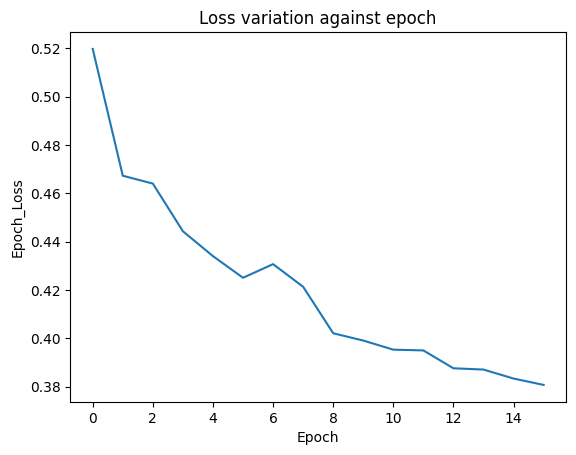

In [37]:
# What else to load on device

loss_vect=Back_PropTT(RNN, loaded_data, optimiser, criterion)
plt.plot(loss_vect)
plt.xlabel("Epoch")
plt.ylabel("Epoch_Loss")
plt.title("Loss variation against epoch")
plt.show()







In [45]:
test_df=pd.read_csv('test.csv',header=None,nrows=100000)
test_df.rename(columns={0:'Label',1:'Title',2:'Review'},inplace=True)
test_df.dropna(inplace=True)
test_df=test_df.reset_index(drop=True)

part_test_df=test_df[42000:50000].copy()
part_test_df['Title']=part_test_df['Title'].parallel_apply(complete_preprocessor)
part_test_df['Review']=part_test_df['Review'].parallel_apply(complete_preprocessor)
part_test_df['Label']-=1

part_test_df=part_test_df[(part_test_df['Title'].apply(len)>0)&(part_test_df['Review'].apply(len)>0)]
part_test_df=part_test_df.reset_index(drop=True)

Final Loss: 0.4015566371189763
Confusion Matrix: [[3093  883]
 [ 550 3449]]


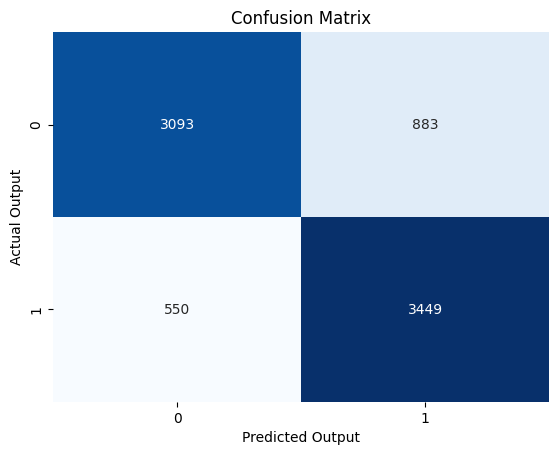

In [46]:
int_tokens(part_test_df, Vocab)
test_label_tensor,test_title_tensor,test_review_tensor=seq_pad(part_test_df)

test_data=TensorDataset(test_label_tensor, test_title_tensor, test_review_tensor)
test_data=DataLoader(test_data,batch_size=128,shuffle=False)

from sklearn.metrics import confusion_matrix,average_precision_score

RNN.eval()
with torch.no_grad():
  prediction_on_test=[]
  final_loss=0
  for test_label_batch, test_title_batch, test_review_batch in test_data:
    predicted_output=RNN(test_title_batch.to(device),test_review_batch.to(device))
    prediction_on_test.extend(np.array(predicted_output>=0).astype(int).flatten())

    loss=criterion(predicted_output.view(-1),test_label_batch.float().to(device))
    final_loss+=loss.item()*test_label_batch.shape[0]

  final_loss/=len(test_data.dataset)
  print(f"Final Loss: {final_loss}")

  ConfusionMatrix=confusion_matrix(test_label_tensor,prediction_on_test)
  print(f"Confusion Matrix: {ConfusionMatrix}")

  sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Output')
  plt.ylabel('Actual Output')
  plt.title('Confusion Matrix')
  plt.show()


#                   Performance-Metrics for RNN Architecture as implemented above

# Accuracy: 0.82
# Precision: 0.87
# Recall: 0.79
# F1 Score: 0.82





      Label                                              Title  \
0         1                             [tensor(1), tensor(1)]   
1         1  [tensor(1), tensor(1), tensor(1), tensor(1), t...   
2         0       [tensor(1), tensor(1), tensor(1), tensor(1)]   
3         1  [tensor(1), tensor(1), tensor(1), tensor(1), t...   
4         1                             [tensor(1), tensor(1)]   
...     ...                                                ...   
7968      1       [tensor(1), tensor(1), tensor(1), tensor(1)]   
7969      1                  [tensor(1), tensor(1), tensor(1)]   
7970      0       [tensor(1), tensor(1), tensor(1), tensor(1)]   
7971      1       [tensor(1), tensor(1), tensor(1), tensor(1)]   
7972      1                             [tensor(1), tensor(1)]   

                                                 Review  
0     [tensor(1), tensor(1), tensor(1), tensor(1), t...  
1     [tensor(1), tensor(1), tensor(1), tensor(1), t...  
2     [tensor(1), tensor(1), tens

In [41]:
#                                   LSTM Implementation

class LSTM_model(nn.Module):
  def __init__(self,vocab, global_map, embed_dim, hidden_dim, output_dim, pad_idx=0, dropout=0.25):
    super(LSTM_model,self).__init__()
    embedding_matrix=np.zeros((len(vocab),embed_dim))
    embedding_matrix=self.create_embedding_matrix(vocab,global_map,embed_dim)
    self.embedding=nn.Embedding.from_pretrained(torch.tensor(embedding_matrix,dtype=torch.float),freeze=True)

    self.lstm_layers=nn.ModuleList()
    l_dim=embed_dim
    for dim in hidden_dim:
      self.lstm_layers.append(nn.LSTM(4*l_dim,dim,bidirectional=True,batch_first=True))
      l_dim=dim

    self.fc=nn.Linear(4*hidden_dim[-1],output_dim)
    self.dropout=nn.Dropout(dropout)

  def create_embedding_matrix(self, vocab, glove_map, embed_dim):
    embedding_output=np.zeros((len(vocab),embed_dim))
    for word,index in vocab.items():
      if word in glove_map:
        embedding_output[index]=glove_map[word]
      else:
        if index==1:
          embedding_output[index]=np.zeros((embed_dim,))
        elif index==2:
          embedding_output[index]=np.random.uniform(0,0.5,embed_dim)
        else:
          embedding_output[index]=np.random.uniform(-0.5,0,embed_dim)

    return embedding_output

  def forward(self, title_batch, review_batch):
    title_output=self.embedding(title_batch)
    review_output=self.embedding(review_batch)
    if self.training:
      title_output=self.dropout(title_output)
      review_output=self.dropout(review_output)

    for layer in self.lstm_layers:
      title_output,(title_hidden,title_cell)=layer(title_output)
      review_output,(review_hidden,review_cell)=layer(review_output)

      if self.training:
        title_output=self.dropout(title_output)
        review_output=self.dropout(review_output)

    fw_final_title,bw_final_title=title_hidden[-2,:,:],title_hidden[-1,:,:]
    final_title=torch.cat((fw_final_title,bw_final_title),dim=1)
    fw_final_review,bw_final_review=review_hidden[-2,:,:],review_hidden[-1,:,:]
    final_review=torch.cat((fw_final_review,bw_final_review),dim=1)

    final_hidden=torch.cat((final_title,final_review),dim=1)
    if self.training:
      final_hidden=self.dropout(final_hidden)
    logits = self.fc(final_hidden)
    return logits


hidden_dim=[100,32,16]

LSTM=LSTM_model(Vocab, glove_embed, 100, hidden_dim, 1)
criterion=nn.BCEWithLogitsLoss()
optimiser=optim.Adam(LSTM.parameters(),lr=0.001)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LSTM=LSTM.to(device)
criterion=criterion.to(device)

def Back_PropTT(RNN, loaded_data, optimiser, criterion):

  from tqdm import tqdm
  LSTM.train()
  max_epochs=32
  lr_min=1e-7
  epoch_count=1
  scheduler=ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=3, threshold=1e-3, threshold_mode='rel')
  loss_progression=[]

  while epoch_count<=max_epochs:
    epoch_loss=0

    for label_batch, title_batch, review_batch in tqdm(loaded_data):
      predicted_output=LSTM(title_batch,review,batch)
      loss=criterion(predicted_output.view(-1),label_batch.float.to(device))

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      epoch_loss+=loss.item()*label_batch.shape[0]

    epoch_loss/=len(dataset)
    loss_progression.append(epoch_loss)

    print(f"Epoch:{epoch_count} Loss:{epoch_loss}")
    scheduler.step(epoch_loss)

    current_lr=optimiser.param_groups[0]['lr']
    if current_lr<=lr_min:
      print('Very slow learning rate')
      break

    if((epoch_count>2)&(int(loss_progression[-2]*1000)<int(loss_progression[-1]*1000))):
      for param_group in optimiser.param_groups:
        param_group['lr']*=0.1

    epoch_count+=1
    return loss_progression





TypeError: LSTM_model.create_embedding_matrix() missing 1 required positional argument: 'embed_dim'